In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy  as np
import math

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
look_back      = params.look_back_tick 
features_cols  = params.features_cols_tick
label_col      = params.label_col
device         = params.device

df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)

df_features = df_feat[features_cols + ['signal','ask','bid']]
df_features 

,vol_15,ma_5,ma_20,close,hour,bb_width_20,high,low,open,vwap_dev,atr_14,r_5,r_1,r_15,obv,signal,ask,bid
2004-01-02 13:09:00,-0.966783,-0.185561,-0.282361,-0.193762,0.493,-0.929333,-0.317313,-0.028125,-0.193147,-0.032030,-1.435516,-0.040971,-0.029212,-0.025534,11.535427,0.005593,0.764807,0.763664
2004-01-02 13:10:00,-0.965007,-0.192087,-0.284115,-0.201725,0.493,-0.921566,-0.324262,-0.037500,-0.201085,-0.036171,-1.432540,-0.054390,-0.029213,-0.033477,11.491025,0.006095,0.764790,0.763647
2004-01-02 13:11:00,-0.963779,-0.200245,-0.286307,-0.209688,0.493,-0.913246,-0.331210,-0.046875,-0.209022,-0.040262,-1.429563,-0.067809,-0.029214,-0.041420,11.441197,0.006642,0.764773,0.763631
2004-01-02 13:12:00,-0.963001,-0.208402,-0.288939,-0.217651,0.493,-0.904541,-0.338159,-0.056250,-0.216960,-0.044296,-1.426587,-0.067810,-0.029214,-0.049363,11.385942,0.007239,0.764757,0.763614
2004-01-02 13:13:00,-0.962622,-0.216560,-0.292008,-0.225614,0.493,-0.895592,-0.345107,-0.065625,-0.224897,-0.048268,-1.423611,-0.067812,-0.029215,-0.057307,11.325262,0.007889,0.764740,0.763597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.507307,0.367023,-0.130453,0.705997,-0.939,0.122381,0.704918,0.500000,0.475806,0.407906,2.024482,1.742521,0.837991,1.317936,0.839704,0.000000,196.962600,196.667400
2025-06-18 20:57:00,0.566581,0.460866,-0.093452,0.478780,-0.939,0.187641,0.836066,0.387097,0.685484,0.263954,2.207440,0.887590,-0.939239,1.115397,0.647913,0.000000,196.822500,196.527500
2025-06-18 20:58:00,0.542508,0.497086,-0.060109,0.470665,-0.939,0.241322,0.508197,0.500000,0.467742,0.254269,2.216153,0.341995,-0.033854,0.828890,0.429218,0.000000,196.817500,196.522500
2025-06-18 20:59:00,0.903328,0.408182,-0.062549,-0.227217,-0.939,0.245429,0.524590,-0.129032,0.475806,-0.173638,2.487280,-0.842944,-2.888426,-0.094079,-0.434952,0.043551,196.387200,196.092800


In [4]:
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat,
    look_back     = params.look_back_tick,
    features_cols = params.features_cols_tick,
    label_col     = params.label_col,
    return_col    = params.return_col,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape,    "(samples,)")
print("  y_ret     =", y_ret.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2270503, 30, 15]) (samples, look_back, features)
  y_sig     = torch.Size([2270503]) (samples,)
  y_ret     = torch.Size([2270503]) (samples,)
  raw_close = torch.Size([2270503])
  raw_bid   = torch.Size([2270503])
  raw_ask   = torch.Size([2270503])
  end_times = (2270503,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1600443, 30, 15])
  y_sig_tr, y_ret_tr = torch.Size([1600443]) torch.Size([1600443])
  X_val = torch.Size([329639, 30, 15])
  y_sig_val, y_ret_val = torch.Size([329639]) torch.Size([329639])
  X_te  = torch.Size([340421, 30, 15])
  y_sig_te, y_ret_te = torch.Size([340421]) torch.Size([340421])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Days  → train=3808, val=783, test=809
Batches → train=119,   val=783,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = len(features_cols),                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(device)   # place model parameters on GPU or CPU as specified

model

DualMemoryLSTM(
  (conv): Conv1d(15, 15, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(15, 64, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (do_short): Dropout(p=0.2, inplace=False)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.2, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [8]:
# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)

In [9]:
# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch and Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

Training sees 3808 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.285996


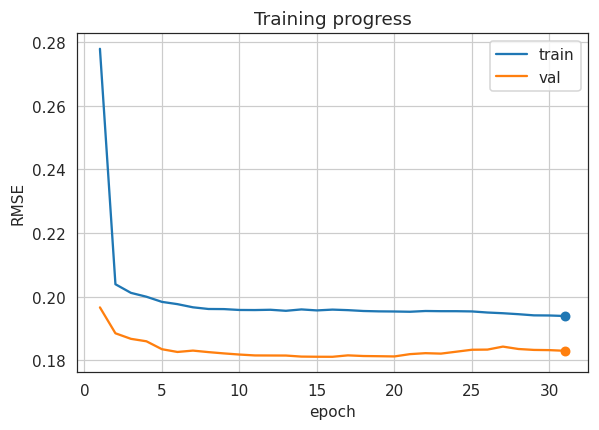

Epoch 1:   0%|          | 0/119 [00:01<?, ?bundle/s]

Epoch 001
TRAIN→ "R": RMSE=0.2779 MAE=0.1962 R2=-0.5404 | "B": Acc=0.7930 Prec=0.4146 Rec=0.1492 F1=0.2194 AUROC=0.7337 | "T": Acc=0.3514 Prec=0.3855 Rec=0.3514 F1=0.3525 AUROC=0.5823
VALID→ "R": RMSE=0.1967 MAE=0.1549 R2=0.1576 | "B": Acc=0.8163 Prec=0.6853 Rec=0.0543 F1=0.1006 AUROC=0.7730 | "T": Acc=0.3638 Prec=0.6044 Rec=0.3638 F1=0.3724 AUROC=0.5814


Epoch 2:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 002
TRAIN→ "R": RMSE=0.2039 MAE=0.1484 R2=0.1706 | "B": Acc=0.8120 Prec=0.5667 Rec=0.1533 F1=0.2414 AUROC=0.7666 | "T": Acc=0.3500 Prec=0.4705 Rec=0.3500 F1=0.3430 AUROC=0.5724
VALID→ "R": RMSE=0.1885 MAE=0.1420 R2=0.2259 | "B": Acc=0.8196 Prec=0.6676 Rec=0.0941 F1=0.1649 AUROC=0.7829 | "T": Acc=0.3615 Prec=0.5767 Rec=0.3615 F1=0.3640 AUROC=0.5850


Epoch 3:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 003
TRAIN→ "R": RMSE=0.2012 MAE=0.1460 R2=0.1924 | "B": Acc=0.8142 Prec=0.5782 Rec=0.1744 F1=0.2680 AUROC=0.7711 | "T": Acc=0.3535 Prec=0.4825 Rec=0.3535 F1=0.3470 AUROC=0.5742
VALID→ "R": RMSE=0.1868 MAE=0.1384 R2=0.2402 | "B": Acc=0.8199 Prec=0.6771 Rec=0.0930 F1=0.1636 AUROC=0.7853 | "T": Acc=0.3624 Prec=0.5847 Rec=0.3624 F1=0.3609 AUROC=0.5881


Epoch 4:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 004
TRAIN→ "R": RMSE=0.2000 MAE=0.1445 R2=0.2022 | "B": Acc=0.8148 Prec=0.5790 Rec=0.1853 F1=0.2808 AUROC=0.7746 | "T": Acc=0.3540 Prec=0.4817 Rec=0.3540 F1=0.3479 AUROC=0.5763
VALID→ "R": RMSE=0.1860 MAE=0.1367 R2=0.2464 | "B": Acc=0.8210 Prec=0.6799 Rec=0.1033 F1=0.1793 AUROC=0.7886 | "T": Acc=0.3625 Prec=0.5871 Rec=0.3625 F1=0.3615 AUROC=0.5878


Epoch 5:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 005
TRAIN→ "R": RMSE=0.1984 MAE=0.1434 R2=0.2150 | "B": Acc=0.8166 Prec=0.5907 Rec=0.1945 F1=0.2926 AUROC=0.7791 | "T": Acc=0.3564 Prec=0.4890 Rec=0.3564 F1=0.3515 AUROC=0.5746
VALID→ "R": RMSE=0.1835 MAE=0.1349 R2=0.2664 | "B": Acc=0.8277 Prec=0.6654 Rec=0.1805 F1=0.2839 AUROC=0.7956 | "T": Acc=0.3618 Prec=0.5862 Rec=0.3618 F1=0.3620 AUROC=0.5886


Epoch 6:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 006
TRAIN→ "R": RMSE=0.1977 MAE=0.1427 R2=0.2206 | "B": Acc=0.8178 Prec=0.5944 Rec=0.2067 F1=0.3067 AUROC=0.7821 | "T": Acc=0.3569 Prec=0.4969 Rec=0.3569 F1=0.3521 AUROC=0.5726
VALID→ "R": RMSE=0.1827 MAE=0.1332 R2=0.2733 | "B": Acc=0.8272 Prec=0.6750 Rec=0.1685 F1=0.2696 AUROC=0.7963 | "T": Acc=0.3628 Prec=0.6088 Rec=0.3628 F1=0.3661 AUROC=0.5899


Epoch 7:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 007
TRAIN→ "R": RMSE=0.1967 MAE=0.1419 R2=0.2285 | "B": Acc=0.8188 Prec=0.6011 Rec=0.2110 F1=0.3124 AUROC=0.7840 | "T": Acc=0.3573 Prec=0.5040 Rec=0.3573 F1=0.3526 AUROC=0.5738
VALID→ "R": RMSE=0.1831 MAE=0.1362 R2=0.2699 | "B": Acc=0.8268 Prec=0.6756 Rec=0.1638 F1=0.2637 AUROC=0.7975 | "T": Acc=0.3617 Prec=0.6140 Rec=0.3617 F1=0.3585 AUROC=0.5903


Epoch 8:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 008
TRAIN→ "R": RMSE=0.1962 MAE=0.1418 R2=0.2326 | "B": Acc=0.8190 Prec=0.6022 Rec=0.2119 F1=0.3134 AUROC=0.7853 | "T": Acc=0.3564 Prec=0.4986 Rec=0.3564 F1=0.3509 AUROC=0.5726
VALID→ "R": RMSE=0.1826 MAE=0.1325 R2=0.2737 | "B": Acc=0.8272 Prec=0.6634 Rec=0.1768 F1=0.2792 AUROC=0.7979 | "T": Acc=0.3632 Prec=0.6164 Rec=0.3632 F1=0.3665 AUROC=0.5904


Epoch 9:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 009
TRAIN→ "R": RMSE=0.1961 MAE=0.1414 R2=0.2329 | "B": Acc=0.8193 Prec=0.6046 Rec=0.2132 F1=0.3152 AUROC=0.7859 | "T": Acc=0.3574 Prec=0.4973 Rec=0.3574 F1=0.3520 AUROC=0.5722
VALID→ "R": RMSE=0.1822 MAE=0.1347 R2=0.2769 | "B": Acc=0.8287 Prec=0.6718 Rec=0.1858 F1=0.2911 AUROC=0.7985 | "T": Acc=0.3628 Prec=0.6165 Rec=0.3628 F1=0.3646 AUROC=0.5909


Epoch 10:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 010
TRAIN→ "R": RMSE=0.1959 MAE=0.1414 R2=0.2350 | "B": Acc=0.8196 Prec=0.6053 Rec=0.2157 F1=0.3181 AUROC=0.7867 | "T": Acc=0.3575 Prec=0.5026 Rec=0.3575 F1=0.3522 AUROC=0.5714
VALID→ "R": RMSE=0.1819 MAE=0.1337 R2=0.2798 | "B": Acc=0.8294 Prec=0.6750 Rec=0.1906 F1=0.2972 AUROC=0.7988 | "T": Acc=0.3637 Prec=0.6170 Rec=0.3637 F1=0.3692 AUROC=0.5912


Epoch 11:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 011
TRAIN→ "R": RMSE=0.1958 MAE=0.1412 R2=0.2352 | "B": Acc=0.8196 Prec=0.6051 Rec=0.2165 F1=0.3189 AUROC=0.7873 | "T": Acc=0.3580 Prec=0.5004 Rec=0.3580 F1=0.3525 AUROC=0.5711
VALID→ "R": RMSE=0.1816 MAE=0.1321 R2=0.2820 | "B": Acc=0.8296 Prec=0.6794 Rec=0.1888 F1=0.2954 AUROC=0.7992 | "T": Acc=0.3635 Prec=0.6190 Rec=0.3635 F1=0.3700 AUROC=0.5914


Epoch 12:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 012
TRAIN→ "R": RMSE=0.1959 MAE=0.1409 R2=0.2345 | "B": Acc=0.8196 Prec=0.6064 Rec=0.2135 F1=0.3159 AUROC=0.7877 | "T": Acc=0.3575 Prec=0.5032 Rec=0.3575 F1=0.3517 AUROC=0.5684
VALID→ "R": RMSE=0.1816 MAE=0.1335 R2=0.2821 | "B": Acc=0.8296 Prec=0.6806 Rec=0.1883 F1=0.2950 AUROC=0.7993 | "T": Acc=0.3633 Prec=0.6216 Rec=0.3633 F1=0.3690 AUROC=0.5910


Epoch 13:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 013
TRAIN→ "R": RMSE=0.1956 MAE=0.1408 R2=0.2370 | "B": Acc=0.8199 Prec=0.6074 Rec=0.2169 F1=0.3197 AUROC=0.7884 | "T": Acc=0.3583 Prec=0.5038 Rec=0.3583 F1=0.3532 AUROC=0.5696
VALID→ "R": RMSE=0.1815 MAE=0.1324 R2=0.2823 | "B": Acc=0.8299 Prec=0.6701 Rec=0.1994 F1=0.3074 AUROC=0.7993 | "T": Acc=0.3623 Prec=0.6237 Rec=0.3623 F1=0.3677 AUROC=0.5911


Epoch 14:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 014
TRAIN→ "R": RMSE=0.1960 MAE=0.1406 R2=0.2337 | "B": Acc=0.8198 Prec=0.6051 Rec=0.2186 F1=0.3211 AUROC=0.7881 | "T": Acc=0.3586 Prec=0.5107 Rec=0.3586 F1=0.3536 AUROC=0.5672
VALID→ "R": RMSE=0.1812 MAE=0.1314 R2=0.2849 | "B": Acc=0.8310 Prec=0.6642 Rec=0.2165 F1=0.3265 AUROC=0.7997 | "T": Acc=0.3615 Prec=0.5924 Rec=0.3615 F1=0.3642 AUROC=0.5914


Epoch 15:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 015
TRAIN→ "R": RMSE=0.1957 MAE=0.1404 R2=0.2361 | "B": Acc=0.8202 Prec=0.6090 Rec=0.2184 F1=0.3216 AUROC=0.7887 | "T": Acc=0.3588 Prec=0.5095 Rec=0.3588 F1=0.3539 AUROC=0.5671
VALID→ "R": RMSE=0.1812 MAE=0.1318 R2=0.2853 | "B": Acc=0.8313 Prec=0.6552 Rec=0.2301 F1=0.3406 AUROC=0.7995 | "T": Acc=0.3626 Prec=0.6204 Rec=0.3626 F1=0.3645 AUROC=0.5915


Epoch 16:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 016
TRAIN→ "R": RMSE=0.1960 MAE=0.1405 R2=0.2341 | "B": Acc=0.8203 Prec=0.6088 Rec=0.2196 F1=0.3228 AUROC=0.7887 | "T": Acc=0.3595 Prec=0.5031 Rec=0.3595 F1=0.3546 AUROC=0.5683
VALID→ "R": RMSE=0.1811 MAE=0.1312 R2=0.2854 | "B": Acc=0.8313 Prec=0.6552 Rec=0.2296 F1=0.3401 AUROC=0.7993 | "T": Acc=0.3628 Prec=0.6240 Rec=0.3628 F1=0.3660 AUROC=0.5908


Epoch 17:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 017
TRAIN→ "R": RMSE=0.1958 MAE=0.1403 R2=0.2354 | "B": Acc=0.8205 Prec=0.6096 Rec=0.2223 F1=0.3258 AUROC=0.7892 | "T": Acc=0.3598 Prec=0.5059 Rec=0.3598 F1=0.3552 AUROC=0.5689
VALID→ "R": RMSE=0.1816 MAE=0.1313 R2=0.2818 | "B": Acc=0.8312 Prec=0.6508 Rec=0.2335 F1=0.3437 AUROC=0.7987 | "T": Acc=0.3615 Prec=0.6080 Rec=0.3615 F1=0.3629 AUROC=0.5913


Epoch 18:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 018
TRAIN→ "R": RMSE=0.1955 MAE=0.1402 R2=0.2375 | "B": Acc=0.8208 Prec=0.6102 Rec=0.2247 F1=0.3284 AUROC=0.7895 | "T": Acc=0.3598 Prec=0.5170 Rec=0.3598 F1=0.3554 AUROC=0.5690
VALID→ "R": RMSE=0.1814 MAE=0.1320 R2=0.2834 | "B": Acc=0.8313 Prec=0.6451 Rec=0.2422 F1=0.3521 AUROC=0.7990 | "T": Acc=0.3645 Prec=0.5893 Rec=0.3645 F1=0.3696 AUROC=0.5903


Epoch 19:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 019
TRAIN→ "R": RMSE=0.1954 MAE=0.1403 R2=0.2384 | "B": Acc=0.8208 Prec=0.6098 Rec=0.2263 F1=0.3300 AUROC=0.7897 | "T": Acc=0.3598 Prec=0.5100 Rec=0.3598 F1=0.3550 AUROC=0.5690
VALID→ "R": RMSE=0.1813 MAE=0.1331 R2=0.2839 | "B": Acc=0.8314 Prec=0.6374 Rec=0.2533 F1=0.3625 AUROC=0.7990 | "T": Acc=0.3623 Prec=0.6139 Rec=0.3623 F1=0.3618 AUROC=0.5889


Epoch 20:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 020
TRAIN→ "R": RMSE=0.1954 MAE=0.1401 R2=0.2387 | "B": Acc=0.8209 Prec=0.6086 Rec=0.2285 F1=0.3322 AUROC=0.7899 | "T": Acc=0.3607 Prec=0.5135 Rec=0.3607 F1=0.3560 AUROC=0.5694
VALID→ "R": RMSE=0.1813 MAE=0.1320 R2=0.2845 | "B": Acc=0.8312 Prec=0.6518 Rec=0.2321 F1=0.3423 AUROC=0.7985 | "T": Acc=0.3617 Prec=0.6222 Rec=0.3617 F1=0.3639 AUROC=0.5909


Epoch 21:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 021
TRAIN→ "R": RMSE=0.1953 MAE=0.1401 R2=0.2394 | "B": Acc=0.8212 Prec=0.6109 Rec=0.2295 F1=0.3336 AUROC=0.7901 | "T": Acc=0.3601 Prec=0.5122 Rec=0.3601 F1=0.3556 AUROC=0.5675
VALID→ "R": RMSE=0.1820 MAE=0.1316 R2=0.2788 | "B": Acc=0.8311 Prec=0.6320 Rec=0.2576 F1=0.3660 AUROC=0.7983 | "T": Acc=0.3594 Prec=0.6025 Rec=0.3594 F1=0.3568 AUROC=0.5905


Epoch 22:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 022
TRAIN→ "R": RMSE=0.1955 MAE=0.1402 R2=0.2375 | "B": Acc=0.8210 Prec=0.6095 Rec=0.2289 F1=0.3328 AUROC=0.7900 | "T": Acc=0.3606 Prec=0.5075 Rec=0.3606 F1=0.3561 AUROC=0.5680
VALID→ "R": RMSE=0.1823 MAE=0.1341 R2=0.2764 | "B": Acc=0.8313 Prec=0.6332 Rec=0.2582 F1=0.3668 AUROC=0.7987 | "T": Acc=0.3626 Prec=0.6153 Rec=0.3626 F1=0.3613 AUROC=0.5908


Epoch 23:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 023
TRAIN→ "R": RMSE=0.1955 MAE=0.1402 R2=0.2380 | "B": Acc=0.8208 Prec=0.6073 Rec=0.2305 F1=0.3342 AUROC=0.7900 | "T": Acc=0.3613 Prec=0.5103 Rec=0.3613 F1=0.3570 AUROC=0.5692
VALID→ "R": RMSE=0.1821 MAE=0.1336 R2=0.2775 | "B": Acc=0.8309 Prec=0.6269 Rec=0.2632 F1=0.3708 AUROC=0.7986 | "T": Acc=0.3625 Prec=0.6153 Rec=0.3625 F1=0.3620 AUROC=0.5898


Epoch 24:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 024
TRAIN→ "R": RMSE=0.1955 MAE=0.1403 R2=0.2380 | "B": Acc=0.8209 Prec=0.6086 Rec=0.2285 F1=0.3323 AUROC=0.7901 | "T": Acc=0.3625 Prec=0.5284 Rec=0.3625 F1=0.3588 AUROC=0.5684
VALID→ "R": RMSE=0.1828 MAE=0.1359 R2=0.2726 | "B": Acc=0.8305 Prec=0.6110 Rec=0.2874 F1=0.3909 AUROC=0.7985 | "T": Acc=0.3631 Prec=0.6066 Rec=0.3631 F1=0.3629 AUROC=0.5905


Epoch 25:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 025
TRAIN→ "R": RMSE=0.1954 MAE=0.1404 R2=0.2386 | "B": Acc=0.8210 Prec=0.6076 Rec=0.2324 F1=0.3362 AUROC=0.7904 | "T": Acc=0.3617 Prec=0.5270 Rec=0.3617 F1=0.3577 AUROC=0.5702
VALID→ "R": RMSE=0.1834 MAE=0.1385 R2=0.2678 | "B": Acc=0.8308 Prec=0.6189 Rec=0.2769 F1=0.3826 AUROC=0.7983 | "T": Acc=0.3624 Prec=0.6194 Rec=0.3624 F1=0.3578 AUROC=0.5894


Epoch 26:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 026
TRAIN→ "R": RMSE=0.1951 MAE=0.1403 R2=0.2413 | "B": Acc=0.8211 Prec=0.6097 Rec=0.2303 F1=0.3343 AUROC=0.7903 | "T": Acc=0.3634 Prec=0.5286 Rec=0.3634 F1=0.3603 AUROC=0.5718
VALID→ "R": RMSE=0.1834 MAE=0.1386 R2=0.2674 | "B": Acc=0.8304 Prec=0.6094 Rec=0.2900 F1=0.3930 AUROC=0.7990 | "T": Acc=0.3625 Prec=0.6187 Rec=0.3625 F1=0.3589 AUROC=0.5899


Epoch 27:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 027
TRAIN→ "R": RMSE=0.1948 MAE=0.1401 R2=0.2430 | "B": Acc=0.8213 Prec=0.6088 Rec=0.2341 F1=0.3382 AUROC=0.7906 | "T": Acc=0.3640 Prec=0.5352 Rec=0.3640 F1=0.3613 AUROC=0.5717
VALID→ "R": RMSE=0.1843 MAE=0.1399 R2=0.2599 | "B": Acc=0.8303 Prec=0.6097 Rec=0.2874 F1=0.3906 AUROC=0.7980 | "T": Acc=0.3614 Prec=0.6099 Rec=0.3614 F1=0.3597 AUROC=0.5896


Epoch 28:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 028
TRAIN→ "R": RMSE=0.1945 MAE=0.1400 R2=0.2453 | "B": Acc=0.8217 Prec=0.6126 Rec=0.2328 F1=0.3374 AUROC=0.7913 | "T": Acc=0.3634 Prec=0.5259 Rec=0.3634 F1=0.3601 AUROC=0.5710
VALID→ "R": RMSE=0.1836 MAE=0.1387 R2=0.2659 | "B": Acc=0.8307 Prec=0.6169 Rec=0.2784 F1=0.3837 AUROC=0.7983 | "T": Acc=0.3623 Prec=0.6279 Rec=0.3623 F1=0.3626 AUROC=0.5895


Epoch 29:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 029
TRAIN→ "R": RMSE=0.1942 MAE=0.1398 R2=0.2482 | "B": Acc=0.8220 Prec=0.6141 Rec=0.2349 F1=0.3399 AUROC=0.7914 | "T": Acc=0.3636 Prec=0.5255 Rec=0.3636 F1=0.3602 AUROC=0.5702
VALID→ "R": RMSE=0.1833 MAE=0.1376 R2=0.2682 | "B": Acc=0.8309 Prec=0.6170 Rec=0.2809 F1=0.3861 AUROC=0.7983 | "T": Acc=0.3617 Prec=0.6279 Rec=0.3617 F1=0.3606 AUROC=0.5893


Epoch 30:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 030
TRAIN→ "R": RMSE=0.1941 MAE=0.1398 R2=0.2485 | "B": Acc=0.8219 Prec=0.6151 Rec=0.2325 F1=0.3374 AUROC=0.7915 | "T": Acc=0.3641 Prec=0.5332 Rec=0.3641 F1=0.3607 AUROC=0.5708
VALID→ "R": RMSE=0.1832 MAE=0.1371 R2=0.2687 | "B": Acc=0.8312 Prec=0.6212 Rec=0.2771 F1=0.3832 AUROC=0.7994 | "T": Acc=0.3633 Prec=0.6281 Rec=0.3633 F1=0.3637 AUROC=0.5894


Epoch 31:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 031
TRAIN→ "R": RMSE=0.1940 MAE=0.1396 R2=0.2498 | "B": Acc=0.8222 Prec=0.6161 Rec=0.2341 F1=0.3392 AUROC=0.7920 | "T": Acc=0.3642 Prec=0.5295 Rec=0.3642 F1=0.3610 AUROC=0.5715
VALID→ "R": RMSE=0.1830 MAE=0.1362 R2=0.2704 | "B": Acc=0.8305 Prec=0.6154 Rec=0.2788 F1=0.3838 AUROC=0.7992 | "T": Acc=0.3631 Prec=0.6271 Rec=0.3631 F1=0.3640 AUROC=0.5892
Early stopping at epoch 31

Champion validation RMSE = 0.181146
Improvement over zero‐baseline =  36.7%


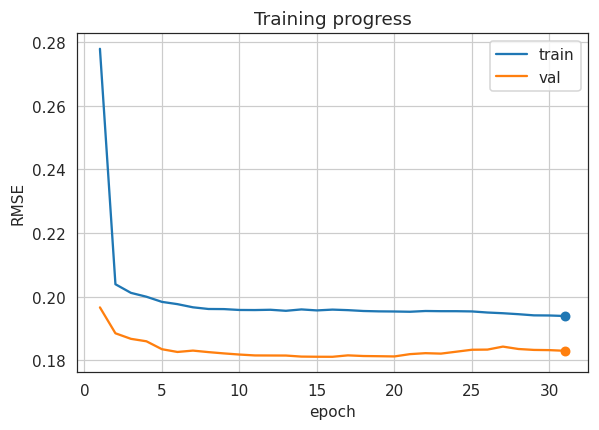

In [10]:
# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    device              = device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")
